In [1]:
import numpy as np
import pandas as pd
import os
import random
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from keras_tuner import Hyperband
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
DATA_PATH = './data/original'
CNN_IMAGE_RESULTS = './results/cnn/images'
CNN_HISTORY_RESULTS = './results/cnn/history'
CNN_REPORT_RESULTS = './results/cnn/reports'
CNN_MODEL_RESULTS = './results/cnn/models'

TRAIN_DIRECTORY = 'train'
VALIDATION_DIRECTORY = 'val'
TEST_DIRECTORY = 'test'

SUB_DIRECTORIES = [TRAIN_DIRECTORY, TEST_DIRECTORY, VALIDATION_DIRECTORY]
CATEGORY_DIRECTORIES = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'Healthy', 'HFMD', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']

In [3]:
def count_images(dir_name):
    for dataset_type in SUB_DIRECTORIES:
        total = 0
        dir_type = os.path.join(dir_name, dataset_type)
        print(f"============ {dataset_type} dataset ===========")
        for category in os.listdir(dir_type):
            category_path = os.path.join(dir_type, category)
            if not os.path.isdir(category_path):
                continue
            images = [img for img in os.listdir(category_path) if img.endswith(('jpg','jpeg'))]
            print(f"Number of images in {category_path.split('/')[-1]}: {len(images)}")
            total += len(images)
        print(f"Total image count: {total}")
        print("")

In [4]:
count_images(DATA_PATH)

============ train dataset ===========
Number of images in Benign keratosis-like lesions: 1000
Number of images in Cowpox: 792
Number of images in Healthy: 1000
Number of images in Actinic keratoses: 693
Number of images in Melanoma: 1000
Number of images in HFMD: 1000
Number of images in Melanocytic nevi: 1000
Number of images in Measles: 660
Number of images in Chickenpox: 900
Number of images in Basal cell carcinoma: 1000
Number of images in Squamous cell carcinoma: 502
Number of images in Monkeypox: 1000
Number of images in Dermatofibroma: 191
Number of images in Vascular lesions: 202
Total image count: 10940

============ test dataset ===========
Number of images in Benign keratosis-like lesions: 100
Number of images in Cowpox: 99
Number of images in Healthy: 100
Number of images in Actinic keratoses: 88
Number of images in Melanoma: 100
Number of images in HFMD: 100
Number of images in Melanocytic nevi: 100
Number of images in Measles: 83
Number of images in Chickenpox: 100
Numbe

In [5]:
def load_images_to_df(base_path, dataset_type):
    path = os.path.join(base_path, dataset_type)
    image_dir = Path(path)

    file_paths = list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

    file_paths = pd.Series(file_paths, name='Path').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([file_paths, labels], axis=1)

    samples = []
    for record in image_df['Label'].unique():
        samples.append(image_df[image_df['Label']==record])
    image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

    return image_df

In [6]:
df_train = load_images_to_df(DATA_PATH, TRAIN_DIRECTORY)
df_train.head(10)

,Path,Label
0,data/original/train/Benign keratosis-like lesi...,Benign keratosis-like lesions
1,data/original/train/Healthy/HEALTHY_59_02_8.jpg,Healthy
2,data/original/train/Melanocytic nevi/ISIC_0010...,Melanocytic nevi
3,data/original/train/Healthy/HEALTHY_26_02_8.jpg,Healthy
4,data/original/train/Monkeypox/MKP_142_06_9.jpg,Monkeypox
5,data/original/train/Vascular lesions/ISIC_0027...,Vascular lesions
6,data/original/train/Melanocytic nevi/ISIC_0011...,Melanocytic nevi
7,data/original/train/Healthy/HEALTHY_58_01_ORIG...,Healthy
8,data/original/train/Cowpox/CWP_19_01_13.jpg,Cowpox
9,data/original/train/Benign keratosis-like lesi...,Benign keratosis-like lesions


In [7]:
df_val = load_images_to_df(DATA_PATH, VALIDATION_DIRECTORY)
df_val.head(10)

,Path,Label
0,data/original/val/Cowpox/CWP_33_06_10.jpg,Cowpox
1,data/original/val/Chickenpox/CHP_53_01_ORIGINA...,Chickenpox
2,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
3,data/original/val/Chickenpox/CHP_03_01_12.jpg,Chickenpox
4,data/original/val/Melanocytic nevi/ISIC_001057...,Melanocytic nevi
5,data/original/val/Measles/MSL_44_01_9.jpg,Measles
6,data/original/val/Measles/MSL_37_01_3.jpg,Measles
7,data/original/val/Melanocytic nevi/ISIC_000176...,Melanocytic nevi
8,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
9,data/original/val/HFMD/HFMD_123_01.jpg,HFMD


In [8]:
df_test = load_images_to_df(DATA_PATH, TEST_DIRECTORY)
df_test.head(10)

,Path,Label
0,data/original/test/Actinic keratoses/ISIC_0071...,Actinic keratoses
1,data/original/test/Basal cell carcinoma/ISIC_0...,Basal cell carcinoma
2,data/original/test/Vascular lesions/ISIC_00707...,Vascular lesions
3,data/original/test/Benign keratosis-like lesio...,Benign keratosis-like lesions
4,data/original/test/Squamous cell carcinoma/ISI...,Squamous cell carcinoma
5,data/original/test/Melanoma/ISIC_0014559_downs...,Melanoma
6,data/original/test/Monkeypox/MKP_126_01_ORIGIN...,Monkeypox
7,data/original/test/Basal cell carcinoma/ISIC_0...,Basal cell carcinoma
8,data/original/test/Actinic keratoses/ISIC_0063...,Actinic keratoses
9,data/original/test/Actinic keratoses/ISIC_0072...,Actinic keratoses


In [9]:
def pie_plot_from_df(df, title):
    pie = df["Label"].value_counts()
    pie.plot(kind="pie", autopct="%1.2f%%")
    plt.ylabel("")
    plt.xlabel(title)
    plt.show()

In [10]:
def show_images_from_df(df, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8), subplot_kw={"xticks":[], "yticks":[]})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Path[i], -1))
        ax.set_title(df.Label[i])
    plt.tight_layout()
    plt.show()

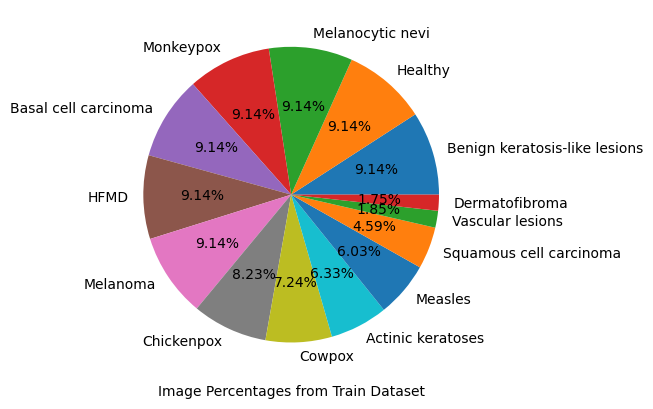

In [11]:
pie_plot_from_df(df_train, "Image Percentages from Train Dataset")

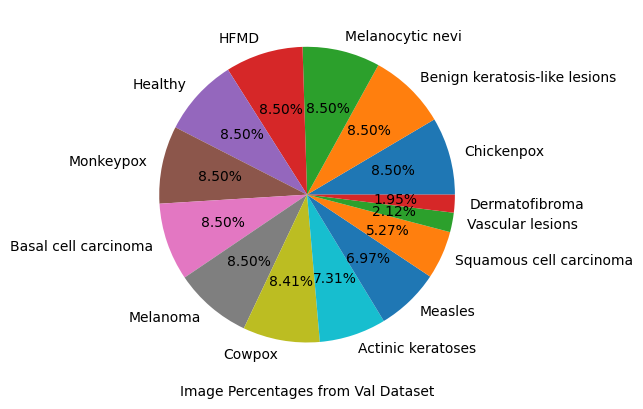

In [12]:
pie_plot_from_df(df_val, "Image Percentages from Val Dataset")

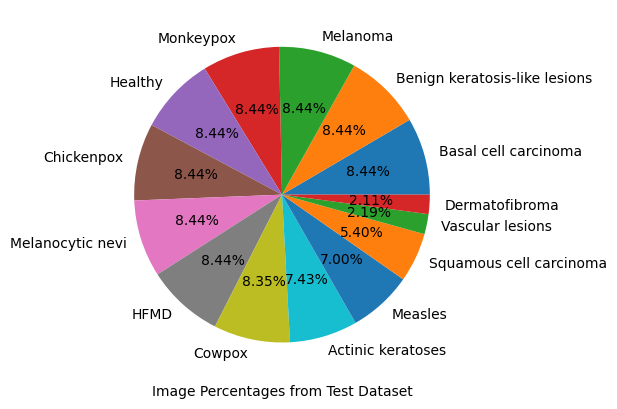

In [13]:
pie_plot_from_df(df_test, "Image Percentages from Test Dataset")

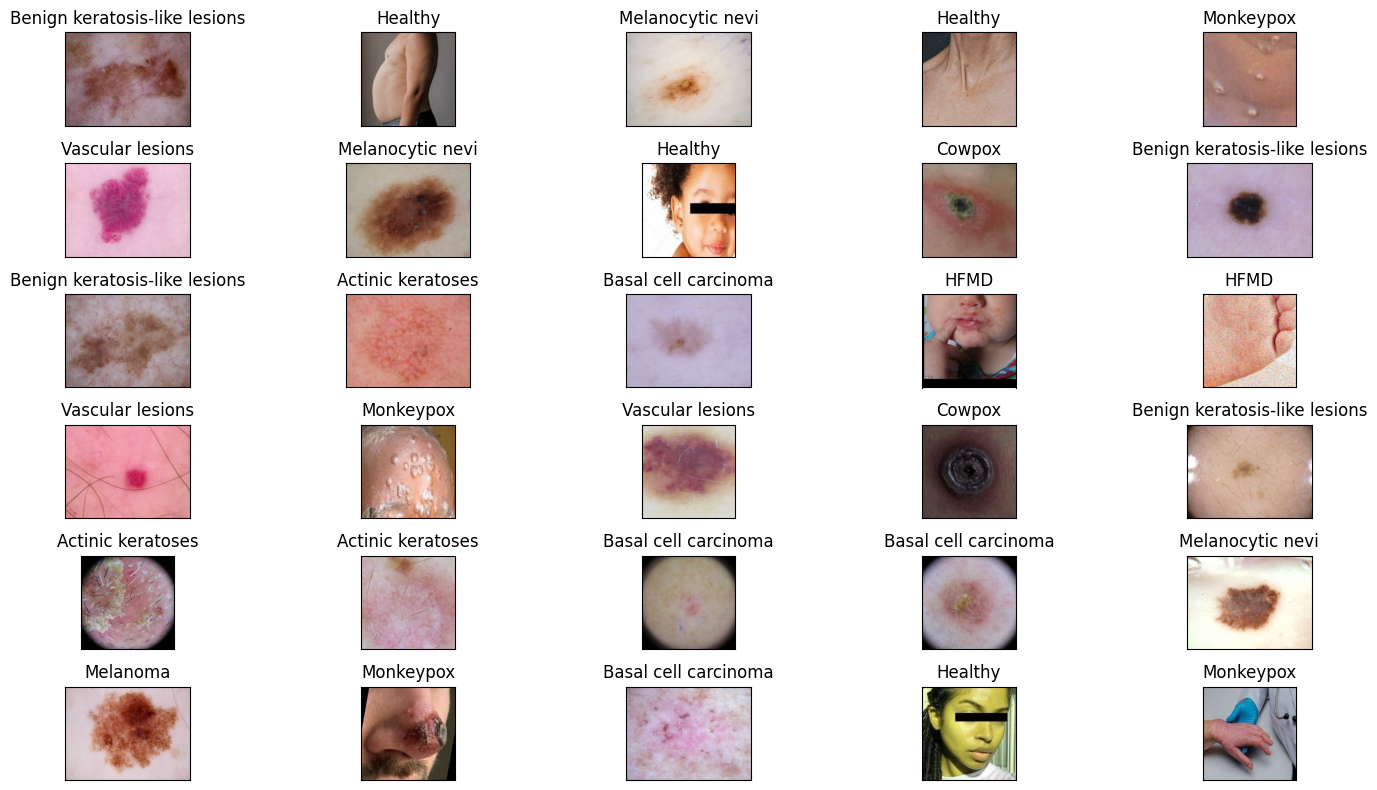

In [14]:
show_images_from_df(df_train, 6, 5)

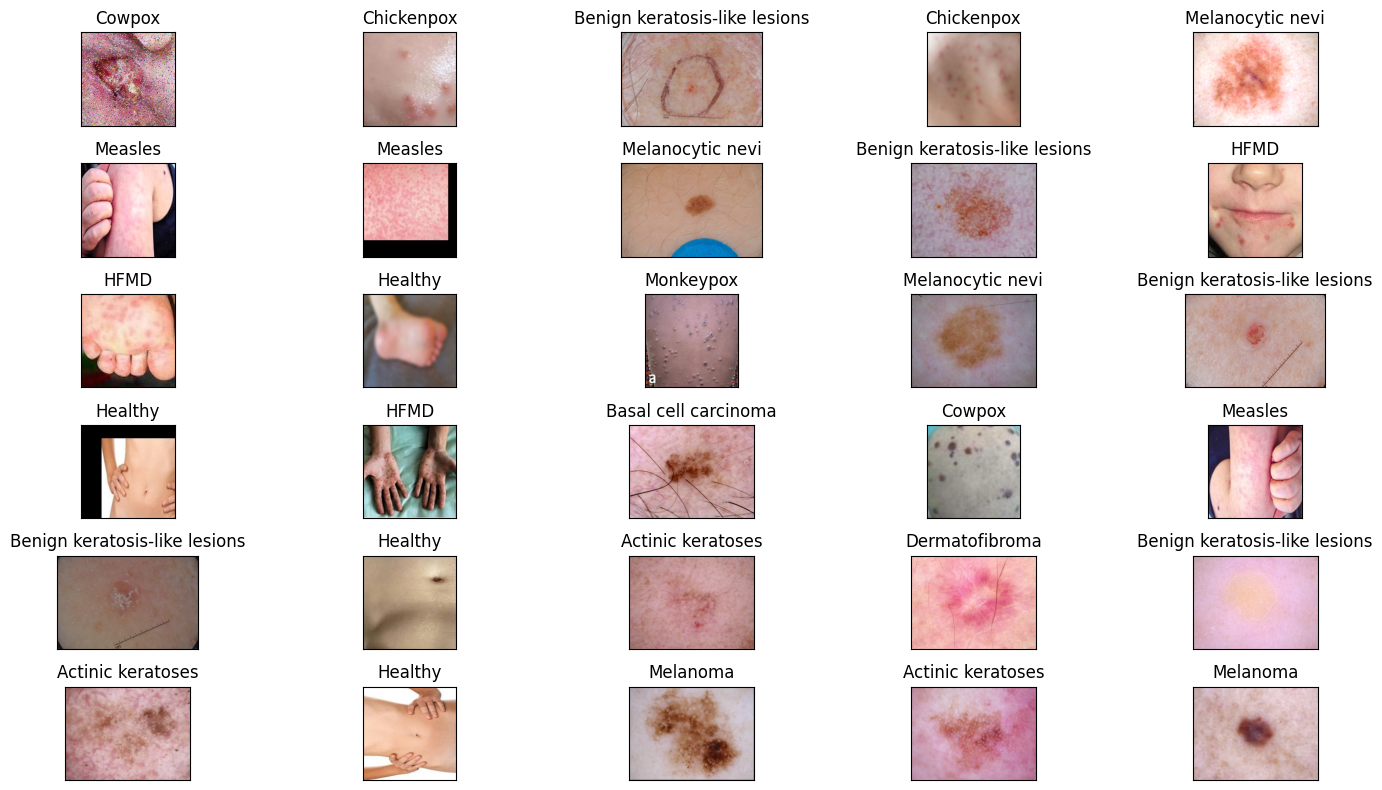

In [15]:
show_images_from_df(df_val, 6, 5)

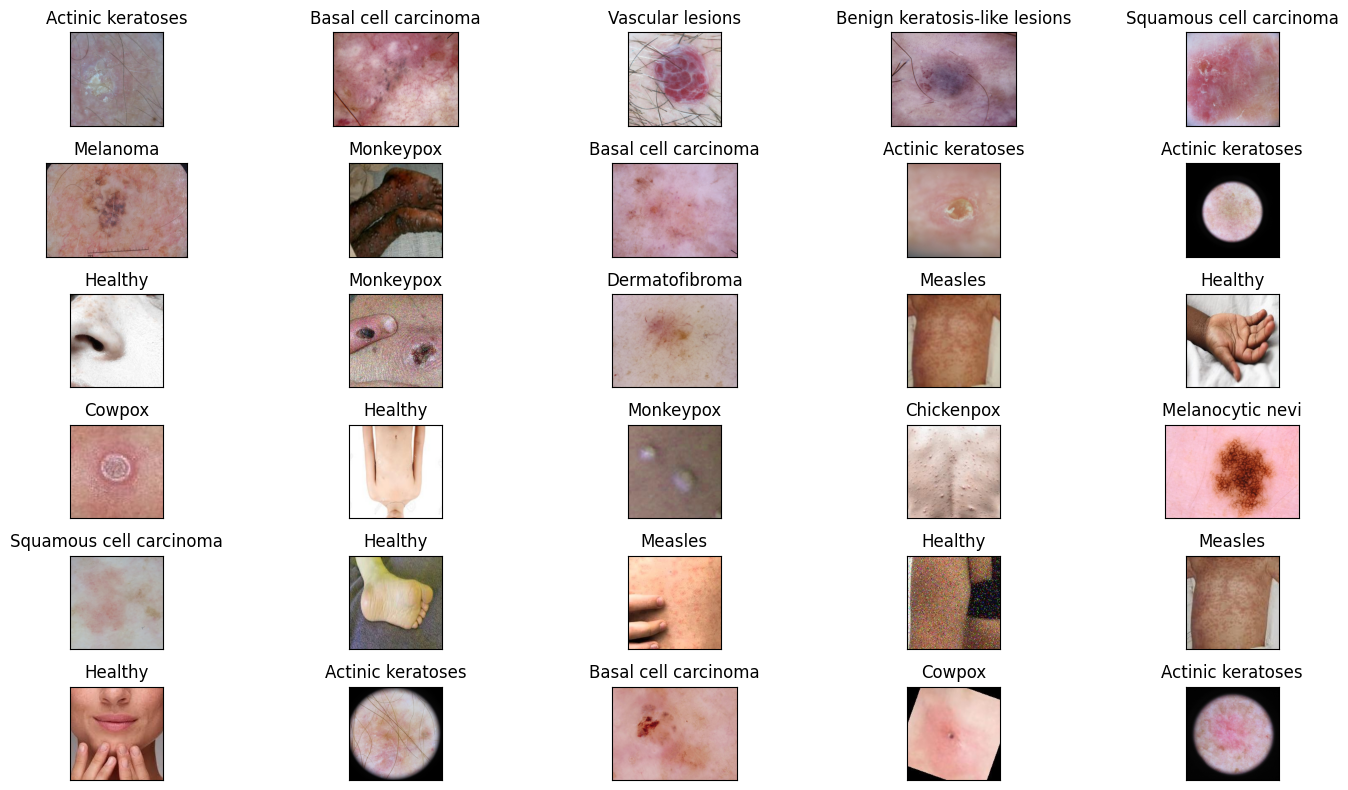

In [16]:
show_images_from_df(df_test, 6, 5)

In [17]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    channel_shift_range=0.1,
    fill_mode="nearest",
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [18]:
def create_dataset(generator, df, subset):
    images = generator.flow_from_dataframe(
        dataframe=df,
        x_col='Path', 
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42)
    print(f"{subset} class indices: {images.class_indices}\n")
    return images

In [19]:
train_dataset = create_dataset(train_generator, df_train, TRAIN_DIRECTORY)
val_dataset = create_dataset(val_generator, df_val, VALIDATION_DIRECTORY)
test_dataset = create_dataset(test_generator, df_test, TEST_DIRECTORY)

Found 10940 validated image filenames belonging to 14 classes.
train class indices: {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 'Benign keratosis-like lesions': 2, 'Chickenpox': 3, 'Cowpox': 4, 'Dermatofibroma': 5, 'HFMD': 6, 'Healthy': 7, 'Measles': 8, 'Melanocytic nevi': 9, 'Melanoma': 10, 'Monkeypox': 11, 'Squamous cell carcinoma': 12, 'Vascular lesions': 13}

Found 1177 validated image filenames belonging to 14 classes.
val class indices: {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 'Benign keratosis-like lesions': 2, 'Chickenpox': 3, 'Cowpox': 4, 'Dermatofibroma': 5, 'HFMD': 6, 'Healthy': 7, 'Measles': 8, 'Melanocytic nevi': 9, 'Melanoma': 10, 'Monkeypox': 11, 'Squamous cell carcinoma': 12, 'Vascular lesions': 13}

Found 1185 validated image filenames belonging to 14 classes.
test class indices: {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 'Benign keratosis-like lesions': 2, 'Chickenpox': 3, 'Cowpox': 4, 'Dermatofibroma': 5, 'HFMD': 6, 'Healthy': 7, 'Measles'

## Model Based on Random Values

2025-01-25 00:34:33.008710: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-01-25 00:34:33.008743: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-25 00:34:33.008747: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-25 00:34:33.008776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-25 00:34:33.008790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


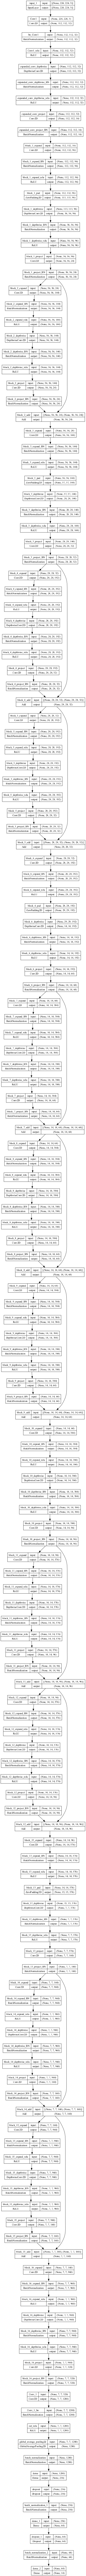

In [20]:
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

for layer in base_model.layers:
    layer.trainable = False

inputs = base_model.input

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
outputs = Dense(len(CATEGORY_DIRECTORIES), activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

tf.keras.utils.plot_model(model, f"{CNN_IMAGE_RESULTS}/mobile_net_v2_model_summary.png", show_shapes=True, dpi=50)

In [21]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)

class_weights = dict(enumerate(class_weights))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min",
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=110,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/110


2025-01-25 00:34:37.187680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


342/342 [==============================] - ETA: 0s - loss: 1.4756 - categorical_accuracy: 0.4900

2025-01-25 00:36:14.674841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


342/342 [==============================] - 102s 294ms/step - loss: 1.4756 - categorical_accuracy: 0.4900 - val_loss: 0.9965 - val_categorical_accuracy: 0.6270
Epoch 2/110
342/342 [==============================] - 101s 295ms/step - loss: 1.1388 - categorical_accuracy: 0.5873 - val_loss: 0.9335 - val_categorical_accuracy: 0.6440
Epoch 3/110
342/342 [==============================] - 103s 301ms/step - loss: 1.0443 - categorical_accuracy: 0.6173 - val_loss: 0.8924 - val_categorical_accuracy: 0.6619
Epoch 4/110
342/342 [==============================] - 102s 297ms/step - loss: 1.0002 - categorical_accuracy: 0.6329 - val_loss: 0.8797 - val_categorical_accuracy: 0.6695
Epoch 5/110
342/342 [==============================] - 102s 297ms/step - loss: 0.9624 - categorical_accuracy: 0.6464 - val_loss: 0.8780 - val_categorical_accuracy: 0.6627
Epoch 6/110
342/342 [==============================] - 103s 300ms/step - loss: 0.9379 - categorical_accuracy: 0.6499 - val_loss: 0.8254 - val_categorical_acc

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{CNN_IMAGE_RESULTS}/mobile_net_v2_training_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{CNN_HISTORY_RESULTS}/mobile_net_v2_history.csv"
history_df.to_csv(history_csv)

In [ ]:
y_pred = model.predict(test_dataset)

y_true = test_dataset.classes
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
report = classification_report(y_true, y_pred, target_names=test_dataset.class_indices.keys())
print("Classification Report:\n", report)

report_file = f"{CNN_REPORT_RESULTS}/mobile_net_v2_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{CNN_IMAGE_RESULTS}/mobile_net_v2_confusion_matrix.png'
plt.savefig(heatmap_file)

In [ ]:
model.save(f"{CNN_MODEL_RESULTS}/mobile_net_v2.h5")

In [ ]:
df_sample = df_test.sample(n=10, random_state=42)
image_dict = dict(zip(df_sample["Path"], df_sample["Label"]))

for path, label in image_dict.items():
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class_idx = np.argmax(preds[0])

    plt.figure(figsize=(4,4)
    plt.imshow(img)
    plt.axis("off")

    reversed_dict = {v: k for k, v in test_dataset.class_indices}
    predicted_class = reversed_dict[predicted_class_idx]
    plt.title(f"Original: {label} | Predicted: {predicted_class}")

## Hyper-parameter Tuned Model

In [ ]:
def build_model_with_hp(hp, base_model, num_classes):
    inputs = base_model.input

    x = base_model.output

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(units=hp.Int("dense_1_units", min_value=128, max_value=512, step=32), activation="relu")(x)
    x = Dropout(rate=hp.Choice("dropout_rate_1", values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]))(x)

    x = BatchNormalization()(x)
    x = Dense(units=hp.Int('dense_2_units', min_value=32, max_value=512, step=16), activation='relu')(x)

    x = Dropout(rate=hp.Choice('dropout_rate_2', values=[0.2,0.3,0.4,0.5,0.6,0.7]))(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model

In [ ]:
def perform_hyperparameter_tuning(model_name, base_model_func, train_dataset, val_dataset, num_classes, max_epochs=110):
    base_model = base_model_func(weights="imagenet", include_top=False, input_shape=(224,224,3))

    tuner = Hyperband(
        lambda hp: build_model_with_hp(hp, base_model, num_classes),
        objective="categorical_accuracy",
        max_epochs=max_epochs,
        factor=3,
        directory="hyperparameter_tuning",
        project_name=model_name
    )

    tuner.search(train_dataset, validation_data=val_dataset, epochs=max_epochs, callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)])
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    print(f"Best hyperparameters for {model_name}:")
    print(f" - Units: {best_hps.get('units')}")
    print(f" - Dropout Rate: {best_hps.get('dropout_rate')}")
    print(f" - Learning Rate: {best_hps.get('learning_rate')}")
    
    return tuner

In [ ]:
tuner = perform_hyperparameter_tuning("MobileNetV2", MobileNetV2, train_dataset, val_dataset, len(CATEGORY_DIRECTORIES))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = build_model_with_hp(best_hps, base_model, len(CATEGORY_DIRECTORIES))
tf.keras.utils.plot_model(model, f"{CNN_IMAGE_RESULTS}/mobile_net_v2_hp_model_summary.png", show_shapes=True, dpi=50)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)

class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_dataset,
    epochs=110,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)],
    class_weight=class_weights
)

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{CNN_IMAGE_RESULTS}/mobile_net_v2_hp_training_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{CNN_HISTORY_RESULTS}/mobile_net_v2_hp_history.csv"
history_df.to_csv(history_csv)

In [ ]:
y_pred = model.predict(test_dataset)

y_true = test_dataset.classes
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
report = classification_report(y_true, y_pred, target_names=test_dataset.class_indices.keys())
print("Classification Report:\n", report)

report_file = f"{CNN_REPORT_RESULTS}/mobile_net_v2_hp_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{CNN_IMAGE_RESULTS}/mobile_net_v2_hp_confusion_matrix.png'
plt.savefig(heatmap_file)

In [ ]:
model.save(f"{CNN_MODEL_RESULTS}/mobile_net_v2_hp.h5")

In [ ]:
df_sample = df_test.sample(n=10, random_state=42)
image_dict = dict(zip(df_sample["Path"], df_sample["Label"]))

for path, label in image_dict:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class_idx = np.argmax(preds[0])

    plt.figure(figsize=(4,4)
    plt.imshow(img)
    plt.axis("off")

    reversed_dict = {v: k for k, v in test_dataset.class_indices}
    predicted_class = reversed_dict[predicted_class_idx]
    plt.title(f"Original: {} | Predicted: {predicted_class}")